<IPython.core.display.Javascript object>


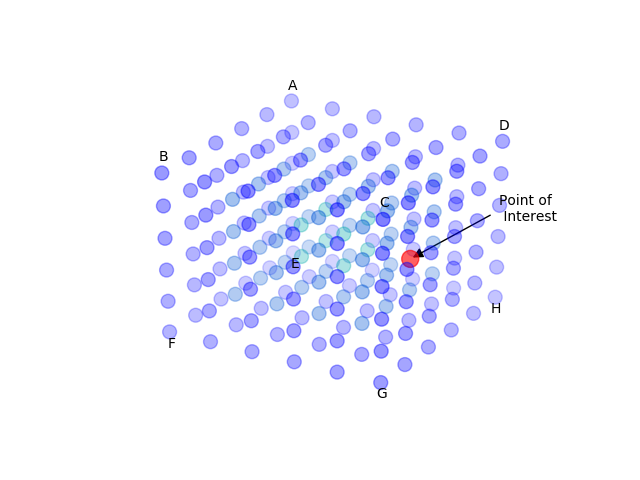

In [31]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import sys
import os
import copy

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import matplotlib.colors as mpclr
import matplotlib.cm as cm
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

sys.path.append('../')
sys.path.append('../paretoviz')
from paretoviz import normalizer as nrm
from paretoviz import plotting as pplt
from paretoviz import decorator as dcor
from paretoviz import palettizer as pltz
from paretoviz.utils import fmt
from paretoviz.utils import vectorops as vops

# we might need to draw arrows.
class Arrow3D(FancyArrowPatch):
    """
    The 3d arrow class
    """
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

def get_layers(pts, L):
    """
    Peel the cube into layers, we need this for coloring
    each layer differently.
    """
    layers = []
    rest = set([i for i in range(len(pts))])
    for l in range(L):
        layer = []
        for i in rest:
            if pts[i][0] == l or pts[i][0] == L - (l + 1) \
                or pts[i][1] == l or pts[i][1] == L - (l + 1) \
                    or pts[i][2] == l or pts[i][2] == L - (l + 1):
                        layer.append(i)
        if len(layer) > 0:
            rest = rest - set(layer)
            layers.append(layer)
    return layers

def cube(L = 6, s = 100.0, cmap = cm.get_cmap('winter'), alpha = 1.0):
    """
    This function makes a cube of size L^3
    """
    # the length should always be even
    if L % 2 != 0:
        L = L + 1
    # generate L^3 points
    pts = []
    for x in range(0, L):
        for y in range(0, L):
            for z in range(0, L):
                pts.append([x, y, z])
    # now separate the points into layer
    layers = get_layers(pts, L)
    # use this color map for each layer
    clrs = [cmap(1.0 / len(layers) * d) for i,d in enumerate(range(len(layers)))]
    c = [None] * len(pts)
    for li,layer in enumerate(layers):
        for i in layer:
            lst = list(clrs[li])
            lst[-1] = alpha
            c[i] = tuple(lst)
    # return points, size, color and layer indices
    return (pts, [s] * len(pts), c, layers)

path = "../data/cube"
prefix = "cube-3d"
        
# cube dimension and params
L = 6
s = 100
alpha = 0.50

# get the cube points
pts, sz, clr, layers = cube(L, s = s, alpha = alpha)

# change the color and size of the POI
for i in range(len(clr)):
    if pts[i][0] == 4 and pts[i][1] == 3 and pts[i][2] == 2:
        clr[i] = mpclr.to_rgba('r', alpha = 1.0)
        
for i in range(len(sz)):
    if pts[i][0] == 4 and pts[i][1] == 3 and pts[i][2] == 2:
        sz[i] = sz[i] * 1.5

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_axis_off()

[x, y, z] = list(zip(*pts))
ax.scatter(x, y, z, s = sz, c = clr)

ax.text(5, 5, 2.5, "Point of\n Interest")
a = Arrow3D([4.9, 4], [4.9, 3], [2.75, 2], mutation_scale = 15, \
                lw = 1, arrowstyle = "-|>", color = "black")
ax.add_artist(a)

delta = 0.2
ax.text(0 - delta,     (L-1) + delta, (L-1) + delta, "A")
ax.text(0 - delta,     0 + delta,     (L-1) + delta, "B")
ax.text((L-1) - delta, 0 + delta,     (L-1) + delta, "C")
ax.text((L-1) - delta, (L-1) + delta, (L-1) + delta, "D")
#
ax.text(0 - delta,     (L-1) + delta, -0.5 - delta, "E")
ax.text(0 - delta,     0 + delta,     -0.5 - delta, "F")
ax.text((L-1) - delta, 0 + delta,     -0.5 - delta, "G")
ax.text((L-1) - delta, (L-1) + delta, -0.5 - delta, "H")

# save the scatter plot
fpath = os.path.join(path, prefix + "-scatter-marked.pdf")
plt.savefig(fpath, transparent = False)

plt.show()

<IPython.core.display.Javascript object>


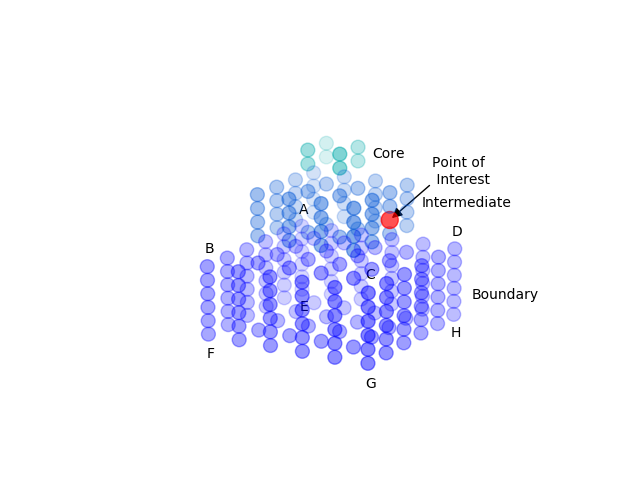

In [32]:
def shift(pts, layer, delta = [0, 0, 0]):
    pts_ = []
    for i in layer:
        pts_.append([pts[i][0] + delta[0], \
                    pts[i][1] + delta[1], \
                    pts[i][2] + delta[2]])
    return pts_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev = 15, azim = -60)
ax.set_aspect('equal')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_axis_off()

[x, y, z] = list(zip(*[pts[i] for i in layers[0]]))
ax.scatter(x, y, z, s = [sz[i] for i in layers[0]], c = [clr[i] for i in layers[0]])

pts_ = shift(pts, layers[1], delta = [0, 0, 6])
[x, y, z] = list(zip(*pts_))
ax.scatter(x, y, z, s = [sz[i] for i in layers[1]], c = [clr[i] for i in layers[1]])

pts_ = shift(pts, layers[2], delta = [0, 0, 10])
[x, y, z] = list(zip(*pts_))
ax.scatter(x, y, z, s = [sz[i] for i in layers[2]], c = [clr[i] for i in layers[2]])

delta = 0.2
ax.text(0 - delta, 5 + delta, 5 + 4 * delta, "A")
ax.text(0 - delta, 0 + delta, 5 + 4 * delta, "B")
ax.text(5 - delta, 0 + delta, 5 + 4 * delta, "C")
ax.text(5 - delta, 5 + delta, 5 + 4 * delta, "D")
#
ax.text(0 - delta, 5 + delta, 0 - (10 * delta), "E")
ax.text(0 - delta, 0 + delta, 0 - (10 * delta), "F")
ax.text(5 - delta, 0 + delta, 0 - (10 * delta), "G")
ax.text(5 - delta, 5 + delta, 0 - (10 * delta), "H")

ax.text(4.5, 4.5, 10, "Point of\n Interest")
a = Arrow3D([4.5, 4], [4.5, 3], [10, 8], mutation_scale = 15, \
                lw = 1, arrowstyle = "-|>", color = "black")
ax.add_artist(a)

ax.text(L + 1, L/3, L/2 + 1, "Boundary")
ax.text(L - 0.5, L/3, L/2 + 1 + 6, "Intermediate")
ax.text(L-2, L/3, L/2 + 1 + 9, "Core")

# save the scatter plot
fpath = os.path.join(path, prefix + "-peeling.pdf")
plt.savefig(fpath, transparent = False)

plt.show()


<IPython.core.display.Javascript object>


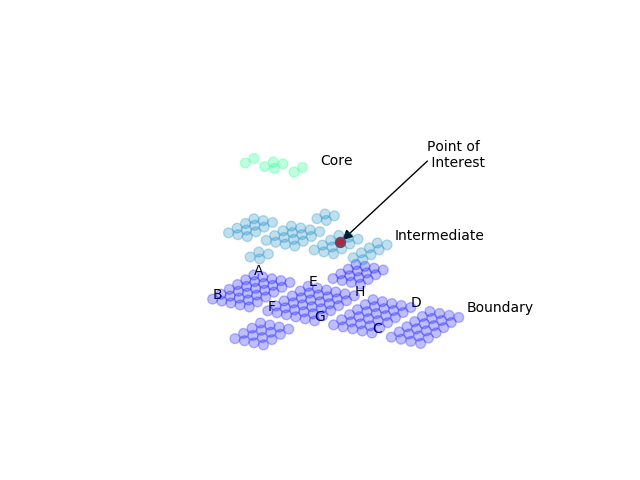

In [33]:
def peeledcube(L = 6, z = 0):
    pts = []
    for x in range(0, L):
        for y in range(0, L):
            pts.append([x, y, z])
            
    for x in range(L + 1, 2 * L):
        for y in range(0, L):
            pts.append([x, y, z])
            
    for x in range(2 * L + 1, (3 * L) - 1):
        for y in range(0, L):
            pts.append([x, y, z])
            
    for x in range(-2, - 1 - L, -1):
        for y in range(0, L):
            pts.append([x, y, z])
            
    for x in range(1, L - 1):
        for y in range(-2, -L, -1):
            pts.append([x, y, z])
            
    for x in range(1, L - 1):
        for y in range(L + 1, 2 * L - 1):
            pts.append([x, y, z])
    return pts

alpha = 0.25
cmap = cm.get_cmap('winter')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_axis_off()

pts_ = peeledcube(6, z = 0)
[x, y, z] = list(zip(*pts_))
ax.scatter(x, y, z, s = s * 0.5, c = [cmap(0.0)] * len(pts_), alpha = alpha)

pts_ = peeledcube(4, z = 1)
[x, y, z] = list(zip(*pts_))
ax.scatter(x, y, z, s = s * 0.5, c = [cmap(0.5)] * len(pts_), alpha = alpha)
ax.scatter(6, 2, 1, s = s * 0.5, c = 'red', alpha = 1.0)

pts_ = peeledcube(2, z = 2)
[x, y, z] = list(zip(*pts_))
ax.scatter(x, y, z, s = s * 0.5, c = [cmap(1.0)] * len(pts_), alpha = alpha)

ax.text(10, 8, 1.75, "Point of\n Interest")
a = Arrow3D([10.1, 6], [8.1, 2], [1.85, 1], mutation_scale = 15, \
                lw = 1, arrowstyle = "-|>", color = "black")
ax.add_artist(a)

ax.text(-L, L-1, 0, "A")
ax.text(-L, 0, 0, "B")
ax.text(L + (L-1), 0, 0, "C")
ax.text(L + (L-1), L-1, 0, "D")
ax.text(0, L-1, 0, "E")
ax.text(0, 0, 0, "F")
ax.text(L-1, 0, 0, "G")
ax.text(L-1, L-1, 0, "H")

ax.text(16, 6, 0, "Boundary")
ax.text(10, 4, 1, "Intermediate")
ax.text(4, 2, 2, "Core")

# save the scatter plot
fpath = os.path.join(path, prefix + "-flattening.pdf")
plt.savefig(fpath, transparent = False)


plt.show()

<IPython.core.display.Javascript object>


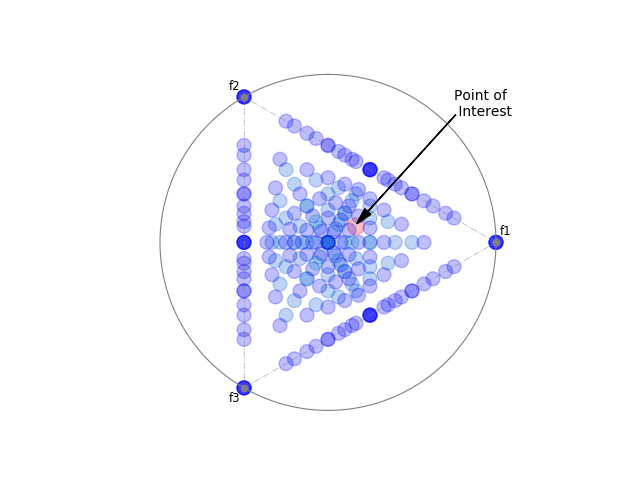

In [34]:
# Do the radviz plot
(fig, ax) = pplt.radviz(pts, s = sz, c = clr, alpha = [alpha])

ax.text(0.75, 0.75, "Point of\n Interest")
plt.arrow(0.76, 0.76, -0.59, -0.65, lw = 1, color = "black", \
          length_includes_head = True, head_length = 0.1, head_width = 0.05)

# save the radviz plot
fpath = os.path.join(path, prefix + "-radviz-marked.pdf")
plt.savefig(fpath, transparent = False)

plt.show()

<IPython.core.display.Javascript object>


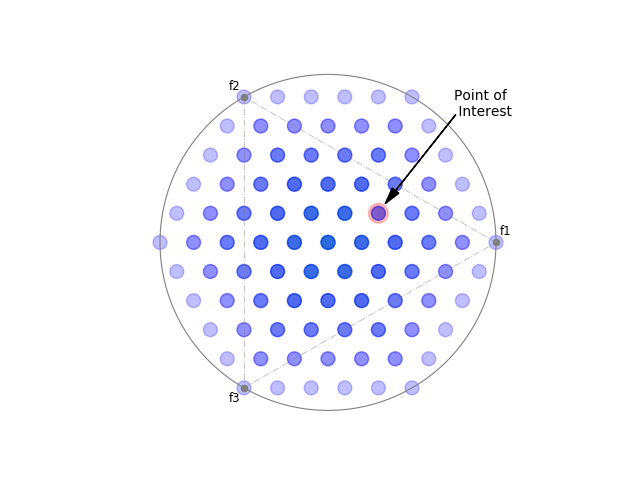

In [35]:
# Do the radviz plot
for i in range(len(sz)):
    if pts[i][0] == 4 and pts[i][1] == 3 and pts[i][2] == 2:
        sz[i] = s * 2.0

(fig, ax) = pplt.star(pts, s = sz, c = clr, alpha = [alpha])

ax.text(0.75, 0.75, "Point of\n Interest")
plt.arrow(0.76, 0.76, -0.42, -0.53, lw = 1, color = "black", \
          length_includes_head = True, head_length = 0.1, head_width = 0.05)

# save the radviz plot
fpath = os.path.join(path, prefix + "-star-marked.pdf")
plt.savefig(fpath, transparent = False)

plt.show()

<IPython.core.display.Javascript object>


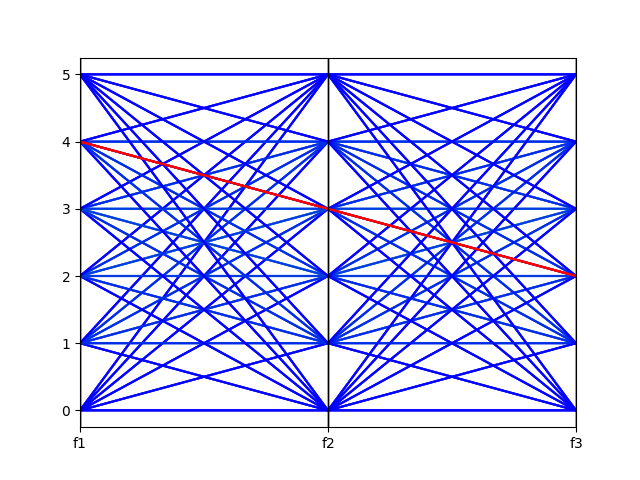

In [36]:
import numpy as np
import pandas as pd

def pcp(X, title = "", show_legend = False, color = None, label = "f{:d}"):
    df = pd.DataFrame(X, columns = [label.format(i+1) for i in range(X.shape[1])])
    df['X'] = ['X_%s' % i for i in range(X.shape[0])]
    if color is None:
        ax = pd.plotting.parallel_coordinates(df, 'X')
        ax.grid(False)
    else:
        ax = pd.plotting.parallel_coordinates(df, 'X', color = color)
        ax.grid(False)
    if not show_legend:
        plt.gca().legend_.remove()
    plt.title(title)

F = np.array(pts)
plt.figure()
pcp(F, "", color = clr)
pcp(np.array([[4, 3, 2], [4, 3, 2]]), "", color = 'r')

# save the radviz plot
fpath = os.path.join(path, prefix + "-pcp-marked.pdf")
plt.savefig(fpath, transparent = False)

plt.show()

<IPython.core.display.Javascript object>


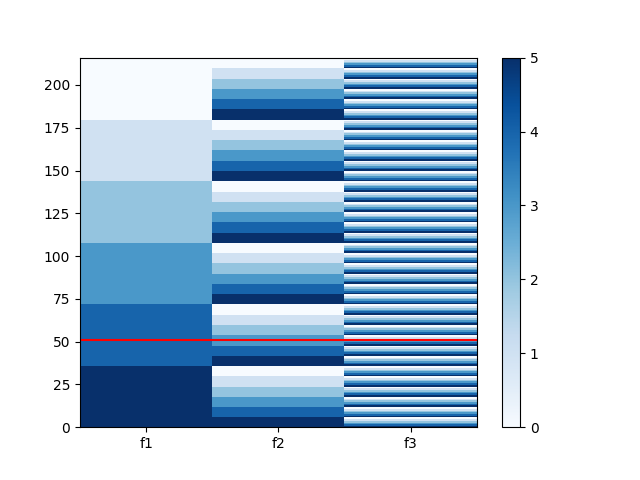

In [37]:
import numpy as np
import pandas as pd

xtickl = ["f{0:d}".format(i+1) for i in range(len(pts[0]))]

points_ = sorted(pts, reverse = True)
data = np.array(points_)
df = pd.DataFrame(data = data[0:,0:], \
                  index = np.arange(len(pts)), \
                  columns = np.arange(len(pts[0])))

fig = plt.figure()
ax = plt.gca()
# ax.set_yticklabels([])
c = ax.pcolor(df, cmap = 'Blues')
plt.xticks(np.arange(0.5, len(xtickl), 1), xtickl)
fig.colorbar(c, ax = ax)

plt.axhline(y = 51.0, color = 'r', linestyle = '-')


# save the radviz plot
fpath = os.path.join(path, prefix + "-heatmap-marked.pdf")
plt.savefig(fpath, transparent = False)

plt.show()

<IPython.core.display.Javascript object>


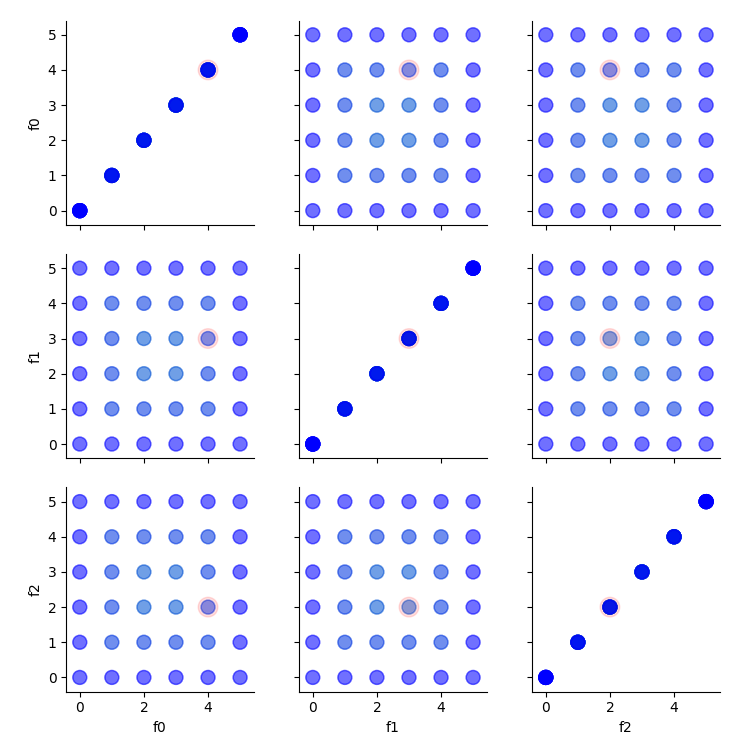

In [38]:
# Do a scatter plot matrix, using seaborn because it can auto-adjust the figsize

import numpy as np
import pandas as pd
import seaborn as sns

for i in range(len(sz)):
    if pts[i][0] == 4 and pts[i][1] == 3 and pts[i][2] == 2:
        sz[i] = s * 2.0

colnames = ["f{0:d}".format(i) for i in range(len(pts[0]))]

data = np.array(pts)
df = pd.DataFrame(data = data[0:,0:], index = np.arange(len(pts)), \
                  columns = np.array(colnames))

g = sns.PairGrid(df)
g.map(plt.scatter, s = sz, alpha = alpha * 0.5, color = clr)

# save the radviz plot
fpath = os.path.join(path, prefix + "-spmatrix-marked.pdf")
plt.savefig(fpath, transparent = False)

plt.show()

In [39]:
import numpy as np
from sklearn.manifold import TSNE

"""
Do t-SNE on the data
"""

rndstate = np.random.RandomState(seed = 1)

U = np.array(pts)
tsne = TSNE(n_components = 2, verbose = True, random_state = rndstate)
F = tsne.fit_transform(U).tolist()
fmt.save(F, "../data/cube/cube-3d-tsne.out")
print("Done.")

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 216 samples in 0.000s...
[t-SNE] Computed neighbors for 216 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 216 / 216
[t-SNE] Mean sigma: 1.264904
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.663475
[t-SNE] KL divergence after 750 iterations: 0.731111
Done.


<IPython.core.display.Javascript object>


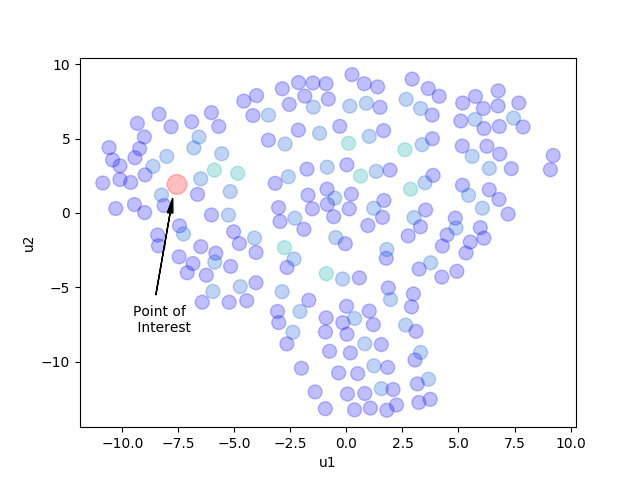

In [53]:
# now plot the t-SNE data points
f = fmt.load("../data/cube/cube-3d-tsne.out")

(fig, ax) = pplt.scatter(f, s = sz, c = clr, alpha = [alpha, alpha], label = 'u{:d}')

ax.text(-9.5, -8.0, "Point of\n Interest")
plt.arrow(-8.5, -5.5, 0.75, 6.5, lw = 1, color = "black", \
          length_includes_head = True, head_length = 1.0, head_width = 0.25)

outfile = "../data/cube/cube-3d-tsne-marked.pdf"
plt.savefig(outfile, transparent = False)

plt.show()

Normalizing 216 data points.
Saving normalized data into ../data/cube/cube-3d-norm.out ...
Computing palette coordinates with 4 layers in invsc mode ...
Saving palette coordinates into ../data/cube/cube-3d-norm-palette-invsc.out ...


<IPython.core.display.Javascript object>


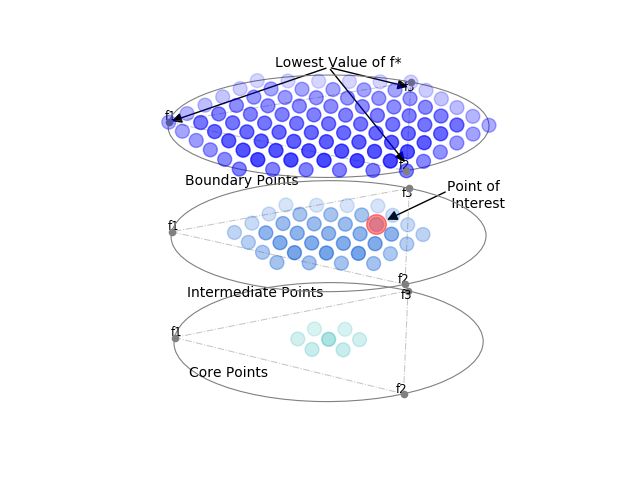

In [16]:
# redo entire paleteeviz plot for the cube data points.

fmt.save(pts, os.path.join(path, prefix + ".out"))

print("Normalizing {0:d} data points.".format(len(pts)))
vals_ = nrm.normalize(pts)
# fmt.cat(pts)

normfname = prefix.split('.')[0] + "-norm.out"
normfile = os.path.join(path, normfname)
print("Saving normalized data into {0:s} ...".format(normfile))
fmt.save(vals_, normfile)

layerfile = normfname.split('.')[0] + "-layers.out"
fp = open(os.path.join(path, layerfile), 'w')
for layer in layers:
    fp.write("\t".join(["{0:d}".format(i) for i in layer]) + "\n")
fp.close()

n_layers = 4
mode = "invsc"
# mode = "invrv"
# mode = "rv"
# mode = "sc"

# tester()
normfpath = os.path.join(path, normfname)
points = fmt.load(normfpath)
layers = fmt.load(os.path.join(path, layerfile), dtype = 'int')

print("Computing palette coordinates with {0:d} layers in {1:s} mode ...".format(n_layers, mode))
if mode == "invsc":
    palette_coords = pltz.palettize_sc(points, layers, n_layers = n_layers, inverted = True)
    palettefpath = os.path.join(path, normfname.split('.')[0] + "-palette-invsc.out")
elif mode == "invrv":
    palette_coords = pltz.palettize_rv(points, layers, n_layers = n_layers, inverted = True)
    palettefpath = os.path.join(path, normfname.split('.')[0] + "-palette-invrv.out")
elif mode == "rv":
    palette_coords = pltz.palettize_rv(points, layers, n_layers = n_layers)
    palettefpath = os.path.join(path, normfname.split('.')[0] + "-palette-rv.out")
elif mode == "sc":
    palette_coords = pltz.palettize_sc(points, layers, n_layers = n_layers)
    palettefpath = os.path.join(path, normfname.split('.')[0] + "-palette-sc.out")
else:
    print("Error: unknown mode \'{0:s}\'\n".format(mode))
    sys.exit(1)

print("Saving palette coordinates into {0:s} ...".format(palettefpath))
pltz.save_palette(palette_coords, palettefpath)

palette_coords = fmt.load(os.path.join(path, prefix + "-norm-palette-" + mode + ".out"))
# do the paletteviz plot with star-coordinate
(fig, ax) = pplt.paletteviz(palette_coords, dim = len(pts[0]), \
            s = sz, c = clr, alpha = None, \
            camera = [24, 92], knee_idx = None, \
            mode = "sc")

# put some markers
ax.text(-0.75, 0.5, -0.5, "Point of\n Interest")
a = Arrow3D([-0.75, -0.35], [0.5, -0.24], [-0.35, -1], mutation_scale = 15, \
                lw = 1, arrowstyle = "-|>", color = "black")
ax.add_artist(a)

ax.text(0.33, 0, 0.5, "Lowest Value of f*")
a = Arrow3D([0, 1], [0, 0], [0.5, 0], mutation_scale = 15, \
                lw = 1, arrowstyle = "-|>", color = "black")
ax.add_artist(a)
a = Arrow3D([0, -0.5], [0, 0.75], [0.5, 0], mutation_scale = 15, \
                lw = 1, arrowstyle = "-|>", color = "black")
ax.add_artist(a)
a = Arrow3D([0, -0.5], [0, -0.75], [0.5, 0], mutation_scale = 15, \
                lw = 1, arrowstyle = "-|>", color = "black")
ax.add_artist(a)
ax.text(0.85, 0.65, -0.25, "Boundary Points")
ax.text(0.85, 0.65, -1.25, "Intermediate Points")
ax.text(0.85, 0.65, -2.00, "Core Points")

# save the paletteviz plot
fig.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, wspace = 0, hspace = 0)
palettefpath = os.path.join(path, prefix + "-norm-palette-" + mode + "-marked.pdf")
plt.savefig(palettefpath, transparent = False, bbox_inches = 'tight', pad_inches = 0)

plt.show()